In [77]:
import os
import scipy
import torch
import random
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import DataLoader
from CBIG_model_pytorch import multi_task_dataset
from CBIG_model_pytorch import stacking


In [8]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [12]:
net = torch.load('meta_matching_v1.0_model.pkl_torch', map_location=torch.device('cpu'))
net.train(False)
print(net)

dnn_4l(
  (fc1): Sequential(
    (0): Dropout(p=0.28836, inplace=False)
    (1): Linear(in_features=87571, out_features=118, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(118, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Sequential(
    (0): Dropout(p=0.28836, inplace=False)
    (1): Linear(in_features=118, out_features=445, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(445, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc3): Sequential(
    (0): Dropout(p=0.28836, inplace=False)
    (1): Linear(in_features=445, out_features=353, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(353, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc4): Sequential(
    (0): Dropout(p=0.28836, inplace=False)
    (1): Linear(in_features=353, out_features=67, bias=True)
  )
)


/Users/elaine/opt/miniconda3/envs/meta-matching/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/elaine/opt/miniconda3/envs/meta-matching/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/elaine/opt/miniconda3/envs/meta-matching/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.

In [4]:
# whole-brain functional connectivity matrix 
schaefer_mat = pd.read_csv('../data/schaefer_400_subcor_19.csv', index_col = 'Subject')
# inconsistency measures: GARP, Varian, Afriat, Houtman-Maks, MMI
behavioral_results = pd.read_csv('../data/aggregate_indices_subs101_148_08Dec2020.csv', index_col = 'Subject')

In [25]:
X = schaefer_mat
# choose only subjects that did a resting scan
Ys = behavioral_results.loc[schaefer_mat.index]
# shorten names of variables
Ys = Ys.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']
# remove perfectly-consistent subjects
inconsistent_subjects = Ys.loc[:, 'GARP Violations']!=0
Ys_incon = Ys.loc[inconsistent_subjects, :]
X_incon = X.loc[inconsistent_subjects, :]

In [73]:
y = np.log(Ys_incon['Afriat Index'].copy())

In [33]:
y_dummy = np.zeros(len(y))
train_dataset = multi_task_dataset(X_incon.to_numpy(), y_dummy, for_finetune=False)

In [103]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=1)

In [104]:
new_X = np.zeros((0, 67))
for (x, _) in train_loader:
    outputs = net(x)
    new_X = np.concatenate((new_X, outputs.data.numpy()), axis=0)

In [105]:
new_X.shape

(34, 67)

In [106]:
from CBIG_model_pytorch import stacking

In [107]:
y_pred = []
y_true = []
loo = sklearn.model_selection.LeaveOneOut()
for train_ind, test_ind in loo.split(X_incon):
    X_train, y_train = new_X[train_ind, :], y.iloc[train_ind]
    X_test, y_test = new_X[test_ind, :], y.iloc[test_ind]
    # normalize y
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)
    y_train = (y_train - mean_y_train) / std_y_train
    y_test = (y_test - mean_y_train) / std_y_train
    
    test_pred = stacking(X_train, X_test, y_train)
    y_pred.append(test_pred[0][0])
    y_true.append(y_test.values[0])

/Users/elaine/opt/miniconda3/envs/meta-matching/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/elaine/opt/miniconda3/envs/meta-matching/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/elaine/opt/miniconda3/envs/meta-matching/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarn

In [108]:
np.corrcoef(y_true, y_pred)

array([[1.        , 0.61796751],
       [0.61796751, 1.        ]])

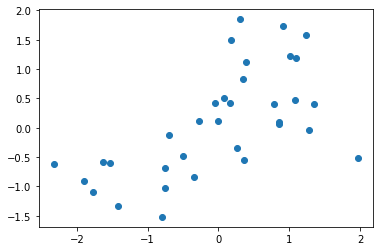

In [109]:
plt.scatter(y_true, y_pred)

In [100]:
meta_match_results = pd.DataFrame({'True' : y_true, 'Predicted' : y_pred})

In [102]:
meta_match_results.to_csv('../data/meta_match_results.csv')
